In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

### Load data

In [135]:
table = pq.read_table("../data/raw/sample_data.parquet.gzip")
df = table.to_pandas()
df.head(2)

,ACTION,TITLE,DESCRIPTION,CLIENT_OS,CHANNEL_TYPE,CREATED_AT,STREAM_URL,STREAM_AUTHOR,PLAYLIST_STREAM_PW,PLAYLIST_USERSTATS_AVG_MAVG,PLAYLIST_STREAM_USERSTATS_MAVG,DISTINCT_USERS,P_EXIT_USERS,STREAM_AGE_ON_PLAYLIST_CREATION,USER_AGE_UNTIL_PLAYLIST_CREATION,DURATION,IS_FAVORITE_CHANNEL,IS_FAVORITE_TAG
0,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",roku,national,2022-07-02 03:52:44.320000+00:00,http://haystack.tv/id/eAkzbFgmc,amazelab,NaN,1.000000,NaN,12324.0,0.016310,15.0,744.0,76.567,0,0
1,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",firetv,national,2022-07-02 04:39:46.149000+00:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.6,0.877527,0.96,12783.0,0.016897,16.0,38542.0,76.567,1,0


### Missing analysis

In [137]:
def data_quality(df):   
    quality_report = {
        'column': [],
        'dtype': [],
        'missing_count': [],
        'missing_pct': [],
        'unique_count': [],
        'unique_pct': []
    }
    
    for col in df.columns:
        quality_report['column'].append(col)
        quality_report['dtype'].append(str(df[col].dtype))
        missing_count = df[col].isnull().sum()
        quality_report['missing_count'].append(missing_count)
        quality_report['missing_pct'].append(round(missing_count / len(df) * 100, 2))
        unique_count = df[col].nunique()
        quality_report['unique_count'].append(unique_count)
        quality_report['unique_pct'].append(round(unique_count / len(df) * 100, 2))
    
    return pd.DataFrame(quality_report)

quality_df = data_quality(df)

high_missing = quality_df[quality_df['missing_pct'] > 0]
if not high_missing.empty:
    display(high_missing[['column', 'missing_pct']])

,column,missing_pct
8,PLAYLIST_STREAM_PW,31.53
9,PLAYLIST_USERSTATS_AVG_MAVG,26.18
10,PLAYLIST_STREAM_USERSTATS_MAVG,67.72
11,DISTINCT_USERS,1.69
12,P_EXIT_USERS,1.69


TARGET DISTRIBUTION


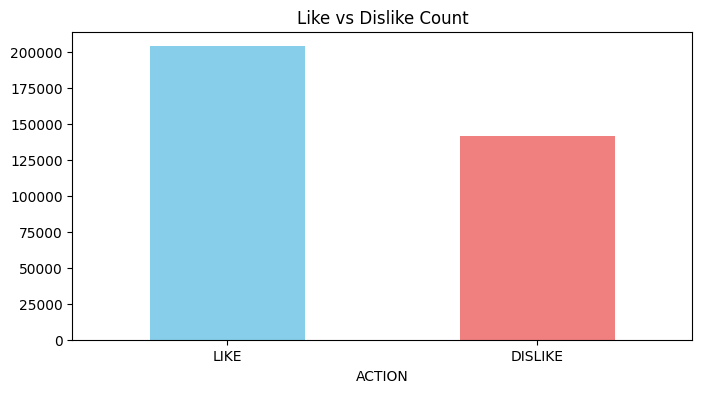

Overall like ratio: 0.591

PLATFORM ANALYSIS
           total_events  like_ratio
CLIENT_OS                          
iphone             3624       0.844
hisense             206       0.772
android           22974       0.762
viziovia            652       0.718
vizio             11337       0.712
appletv            8922       0.693
opera               126       0.690
lg                 9004       0.681
samsung            9786       0.680
firetv            35668       0.613
androidtv         13441       0.608
roku             229060       0.547


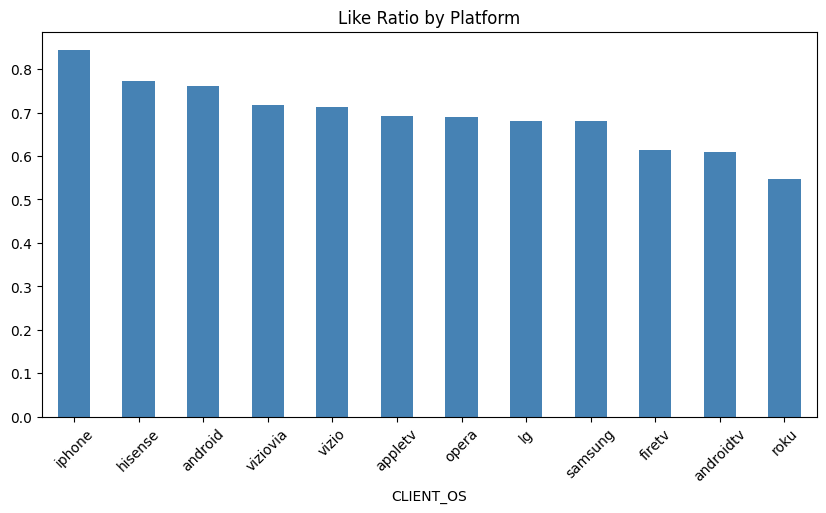

In [138]:
# Target distribution
print("TARGET DISTRIBUTION")
target_counts = df['ACTION'].value_counts()
plt.figure(figsize=(8, 4))
target_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Like vs Dislike Count')
plt.xticks(rotation=0)
plt.savefig('like_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

like_ratio = (df['ACTION'] == 'LIKE').mean()
print(f"Overall like ratio: {like_ratio:.3f}")

# Platform analysis
print("\nPLATFORM ANALYSIS")
platform_analysis = df.groupby('CLIENT_OS', observed=True).agg({
    'ACTION': ['count', lambda x: (x == 'LIKE').mean()]
}).round(3)
platform_analysis.columns = ['total_events', 'like_ratio']
platform_analysis = platform_analysis.sort_values('like_ratio', ascending=False)
print(platform_analysis)

plt.figure(figsize=(10, 5))
platform_analysis['like_ratio'].plot(kind='bar', color='steelblue')
plt.title('Like Ratio by Platform')
plt.xticks(rotation=45)
plt.show()

DURATION ANALYSIS
duration_category
Short         0.600025
Very Short    0.593661
Medium        0.583047
Long          0.558813
Very Long     0.553667
Name: ACTION, dtype: float64

BEST HOURS FOR ENGAGEMENT
hour
6     0.637914
7     0.627837
5     0.616858
19    0.607420
8     0.607115
Name: ACTION, dtype: float64


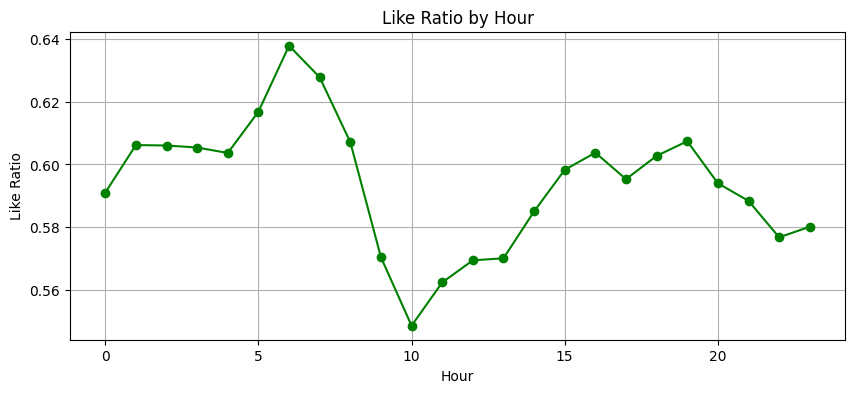

In [139]:
# Duration analysis
df['duration_category'] = pd.cut(df['DURATION'], 
                                bins=[0, 60, 180, 300, 600, float('inf')], 
                                labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

duration_analysis = df.groupby('duration_category', observed=True)['ACTION'].apply(
    lambda x: (x == 'LIKE').mean()
).sort_values(ascending=False)

print("DURATION ANALYSIS")
print(duration_analysis)

# Time analysis
df['hour'] = df['CREATED_AT'].dt.hour
hourly_likes = df.groupby('hour')['ACTION'].apply(lambda x: (x == 'LIKE').mean())

print("\nBEST HOURS FOR ENGAGEMENT")
print(hourly_likes.sort_values(ascending=False).head())

plt.figure(figsize=(10, 4))
hourly_likes.plot(kind='line', marker='o', color='green')
plt.title('Like Ratio by Hour')
plt.xlabel('Hour')
plt.ylabel('Like Ratio')
plt.grid(True)
plt.savefig('like_ratio_hour.png', dpi=300, bbox_inches='tight')
plt.show()

In [140]:
print("FAVORITES ANALYSIS")
fav_combination = df.groupby(['IS_FAVORITE_CHANNEL', 'IS_FAVORITE_TAG'], observed=True)['ACTION'].apply(
    lambda x: (x == 'LIKE').mean()
).round(3)

print("Like ratio by favorites combination:")
for idx, ratio in fav_combination.items():
    print(f"Channel:{idx[0]}, Tag:{idx[1]} -> {ratio}")

# Top authors
print("\nTOP AUTHORS")
author_stats = df.groupby('STREAM_AUTHOR', observed=True).agg({
    'ACTION': ['count', lambda x: (x == 'LIKE').mean()]
}).round(3)
author_stats.columns = ['total_videos', 'like_ratio']

top_authors = author_stats[author_stats['total_videos'] >= 100].sort_values('like_ratio', ascending=False)
print("Top 5 authors (min 100 videos):")
print(top_authors.head())

# Exit rate correlation
clean_data = df.dropna(subset=['P_EXIT_USERS'])
correlation = clean_data['P_EXIT_USERS'].corr((clean_data['ACTION'] == 'LIKE').astype(int))
print(f"\nExit rate vs likes correlation: {correlation:.3f}")

FAVORITES ANALYSIS
Like ratio by favorites combination:
Channel:0, Tag:0 -> 0.492
Channel:0, Tag:1 -> 0.627
Channel:1, Tag:0 -> 0.641
Channel:1, Tag:1 -> 0.84

TOP AUTHORS
Top 5 authors (min 100 videos):
                      total_videos  like_ratio
STREAM_AUTHOR                                 
amazelab                      3123       0.836
buzz60                        1596       0.748
kfor                           248       0.746
wlax                           168       0.744
deutschewelleenglish          1803       0.743

Exit rate vs likes correlation: -0.040
